In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

from modules.elbo import ELBO

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches
data_path = Path('data') / 'yoon'
dat = torch.load(Path(data_path) / 'ryan_natural_fovea_05_PRAIRIE.pt')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

n_prop_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Run optimization

In [4]:
n_dim = 2
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 656.8869291543961
Loss updated
Iteration 1 | Loss: 656.8869291543961
Current loss: 658.3584325835109
Iteration 2 | Loss: 658.3584325835109
Current loss: 673.8176185712218
Iteration 3 | Loss: 673.8176185712218
Current loss: 663.4480083435774
Iteration 4 | Loss: 663.4480083435774
Current loss: 653.8670392110944
Loss updated
Iteration 5 | Loss: 653.8670392110944
Current loss: 684.5425590611994
Iteration 6 | Loss: 684.5425590611994
Current loss: 657.5918783135712
Iteration 7 | Loss: 657.5918783135712
Current loss: 654.5004879981279
Iteration 8 | Loss: 654.5004879981279
Current loss: 694.0488199181855
Iteration 9 | Loss: 694.0488199181855
Current loss: 708.3942040987313
Iteration 10 | Loss: 708.3942040987313
Epoch: 0, Loss: 3301.1722165529372
Epoch: 250, Loss: 1995.7296652472887
Epoch: 500, Loss: 1582.283681312173
Epoch: 750, Loss: 1388.092279893994
Epoch: 1000, Loss: 1278.365439308906
Epoch: 1250, Loss: 1193.650432

### Analyze results

In [5]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

In [6]:
x.shape

torch.Size([1, 2, 11])

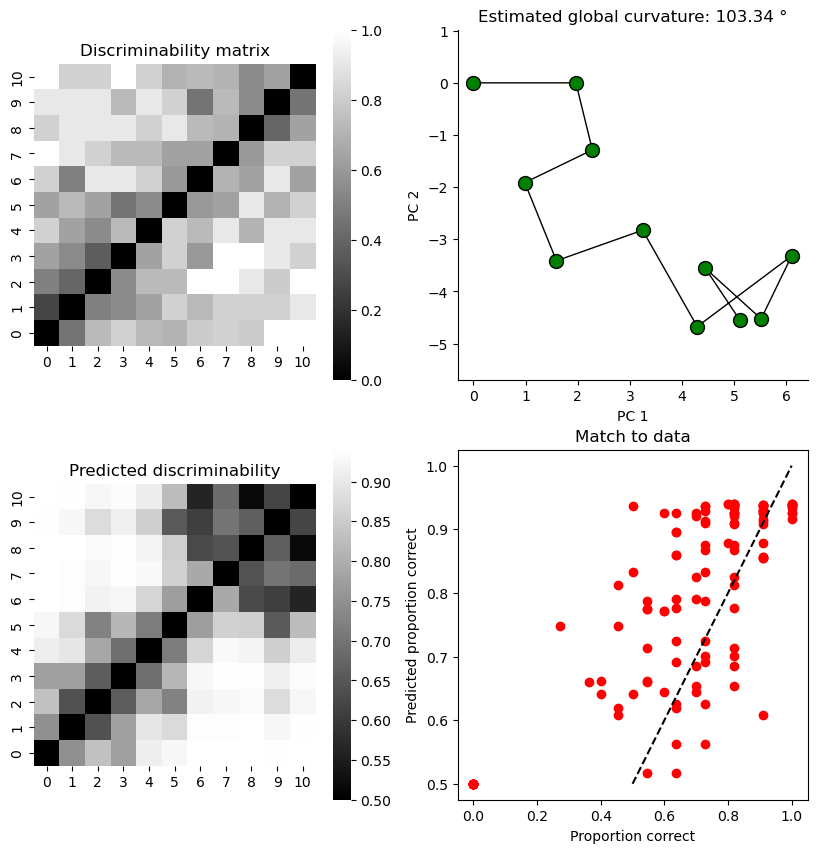

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(n_prop_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(n_prop_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()